In [ ]:
# ============================================================
#  NOTEBOOK 01 — DATA ENGINEERING
#  Projet : Détection de Défauts sur Acier (Steel Defects)
# ============================================================

import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [26]:
# ── Style global ─────
plt.rcParams.update({
    'figure.facecolor'  : '#0f0f1a',
    'axes.facecolor'    : '#1a1a2e',
    'axes.edgecolor'    : '#444',
    'axes.labelcolor'   : 'white',
    'xtick.color'       : 'white',
    'ytick.color'       : 'white',
    'text.color'        : 'white',
    'grid.color'        : '#333',
    'grid.linestyle'    : '--',
    'grid.alpha'        : 0.5,
})

PALETTE = ['#00d4ff','#ff6b6b','#ffd93d','#6bcb77',
           '#c77dff','#ff9f43','#48dbfb','#ff6b81',
           '#a29bfe','#55efc4']


In [27]:
# ── Chemins ───────────────────────────────────────────────
BASE_DIR    = Path("/home/admin1/Documents/SN CNN_DEEP_LEARNING")
IMG_DIR     = BASE_DIR / "dataset/images/images"
LABEL_DIR   = BASE_DIR / "dataset/label/label"

print("✅ Configuration OK")
print(f"📁 Images  : {IMG_DIR}")
print(f"📁 Labels  : {LABEL_DIR}")


✅ Configuration OK
📁 Images  : /home/admin1/Documents/SN CNN_DEEP_LEARNING/dataset/images/images
📁 Labels  : /home/admin1/Documents/SN CNN_DEEP_LEARNING/dataset/label/label


**Scan du Dataset**

In [28]:
dataset_info = []

CLASSES = sorted([d for d in os.listdir(IMG_DIR)
                  if os.path.isdir(IMG_DIR / d)])

print(f"🏷️  Classes détectées : {len(CLASSES)}\n")

for cls in CLASSES:
    cls_path  = IMG_DIR / cls
    images    = list(cls_path.glob("*.jpg")) + \
                list(cls_path.glob("*.png")) + \
                list(cls_path.glob("*.bmp"))

    sizes     = [os.path.getsize(f) / 1024 for f in images] 
    # Lecture dimensions
    dims = []
    for img_path in images[:20]: 
        try:
            with Image.open(img_path) as im:
                dims.append(im.size)  # (W, H)
        except:
            pass

    widths  = [d[0] for d in dims]
    heights = [d[1] for d in dims]

    dataset_info.append({
        'class'       : cls,
        'n_images'    : len(images),
        'size_mean_kb': round(np.mean(sizes), 1) if sizes else 0,
        'size_std_kb' : round(np.std(sizes), 1)  if sizes else 0,
        'width_mean'  : round(np.mean(widths), 0) if widths else 0,
        'height_mean' : round(np.mean(heights),0) if heights else 0,
    })

df = pd.DataFrame(dataset_info).sort_values('n_images', ascending=False)
df['ratio_%'] = (df['n_images'] / df['n_images'].sum() * 100).round(2)

print(df.to_string(index=False))
print(f"\n📸 Total images : {df['n_images'].sum()}")

🏷️  Classes détectées : 10

        class  n_images  size_mean_kb  size_std_kb  width_mean  height_mean  ratio_%
    silk_spot       650         416.7         58.0      2048.0       1000.0    28.19
   water_spot       289         395.2         59.7      2048.0       1000.0    12.53
 welding_line       273         435.5        100.5      2048.0       1000.0    11.84
 crescent_gap       226         349.2         76.7      2048.0       1000.0     9.80
punching_hole       219         423.6         60.2      2048.0       1000.0     9.50
    inclusion       216         381.0         78.5      2048.0       1000.0     9.37
     oil_spot       204         389.5         82.1      2048.0       1000.0     8.85
waist folding       146         458.6        107.8      2048.0       1000.0     6.33
       crease        52         465.1        105.9      2048.0       1000.0     2.25
   rolled_pit        31         487.9         99.7      2048.0       1000.0     1.34

📸 Total images : 2306


**Distribution des Classes**

In [29]:
max_count  = df['n_images'].max()
min_count  = df['n_images'].min()
imb_ratio  = round(max_count / min_count, 2)

df['imbalance_ratio'] = (max_count / df['n_images']).round(2)
df['status'] = df['imbalance_ratio'].apply(
    lambda x: '🟢 Équilibré'   if x < 1.5  else
              '🟡 Modéré'      if x < 3.0  else
              '🔴 Déséquilibré'
)

print("=" * 60)
print("  ⚠️  ANALYSE DU CLASS IMBALANCE")
print("=" * 60)
print(f"\n  Classe majoritaire : {df.iloc[0]['class']} "
      f"({max_count} images)")
print(f"  Classe minoritaire : {df.iloc[-1]['class']} "
      f"({min_count} images)")
print(f"  Ratio global       : {imb_ratio}x")
print()


  ⚠️  ANALYSE DU CLASS IMBALANCE

  Classe majoritaire : silk_spot (650 images)
  Classe minoritaire : rolled_pit (31 images)
  Ratio global       : 20.97x



In [30]:
# Tableau coloré
display_df = df[['class','n_images','ratio_%',
                 'imbalance_ratio','status']].copy()
display_df.columns = ['Classe','Images','Ratio %',
                      'Imbalance x','Statut']
print(display_df.to_string(index=False))

print("\n" + "=" * 60)
if imb_ratio > 3:
    print("  🔴 DÉSÉQUILIBRE IMPORTANT détecté !")
    print("  → Stratégie recommandée : WeightedRandomSampler")
    print("  → + Augmentation ciblée sur classes minoritaires")
elif imb_ratio > 1.5:
    print("  🟡 DÉSÉQUILIBRE MODÉRÉ détecté")
    print("  → Stratégie recommandée : Class weights dans la loss")
else:
    print("  🟢 Dataset bien équilibré !")
print("=" * 60)

       Classe  Images  Ratio %  Imbalance x         Statut
    silk_spot     650    28.19         1.00    🟢 Équilibré
   water_spot     289    12.53         2.25       🟡 Modéré
 welding_line     273    11.84         2.38       🟡 Modéré
 crescent_gap     226     9.80         2.88       🟡 Modéré
punching_hole     219     9.50         2.97       🟡 Modéré
    inclusion     216     9.37         3.01 🔴 Déséquilibré
     oil_spot     204     8.85         3.19 🔴 Déséquilibré
waist folding     146     6.33         4.45 🔴 Déséquilibré
       crease      52     2.25        12.50 🔴 Déséquilibré
   rolled_pit      31     1.34        20.97 🔴 Déséquilibré

  🔴 DÉSÉQUILIBRE IMPORTANT détecté !
  → Stratégie recommandée : WeightedRandomSampler
  → + Augmentation ciblée sur classes minoritaires


**Visualisation Samples par Classe**

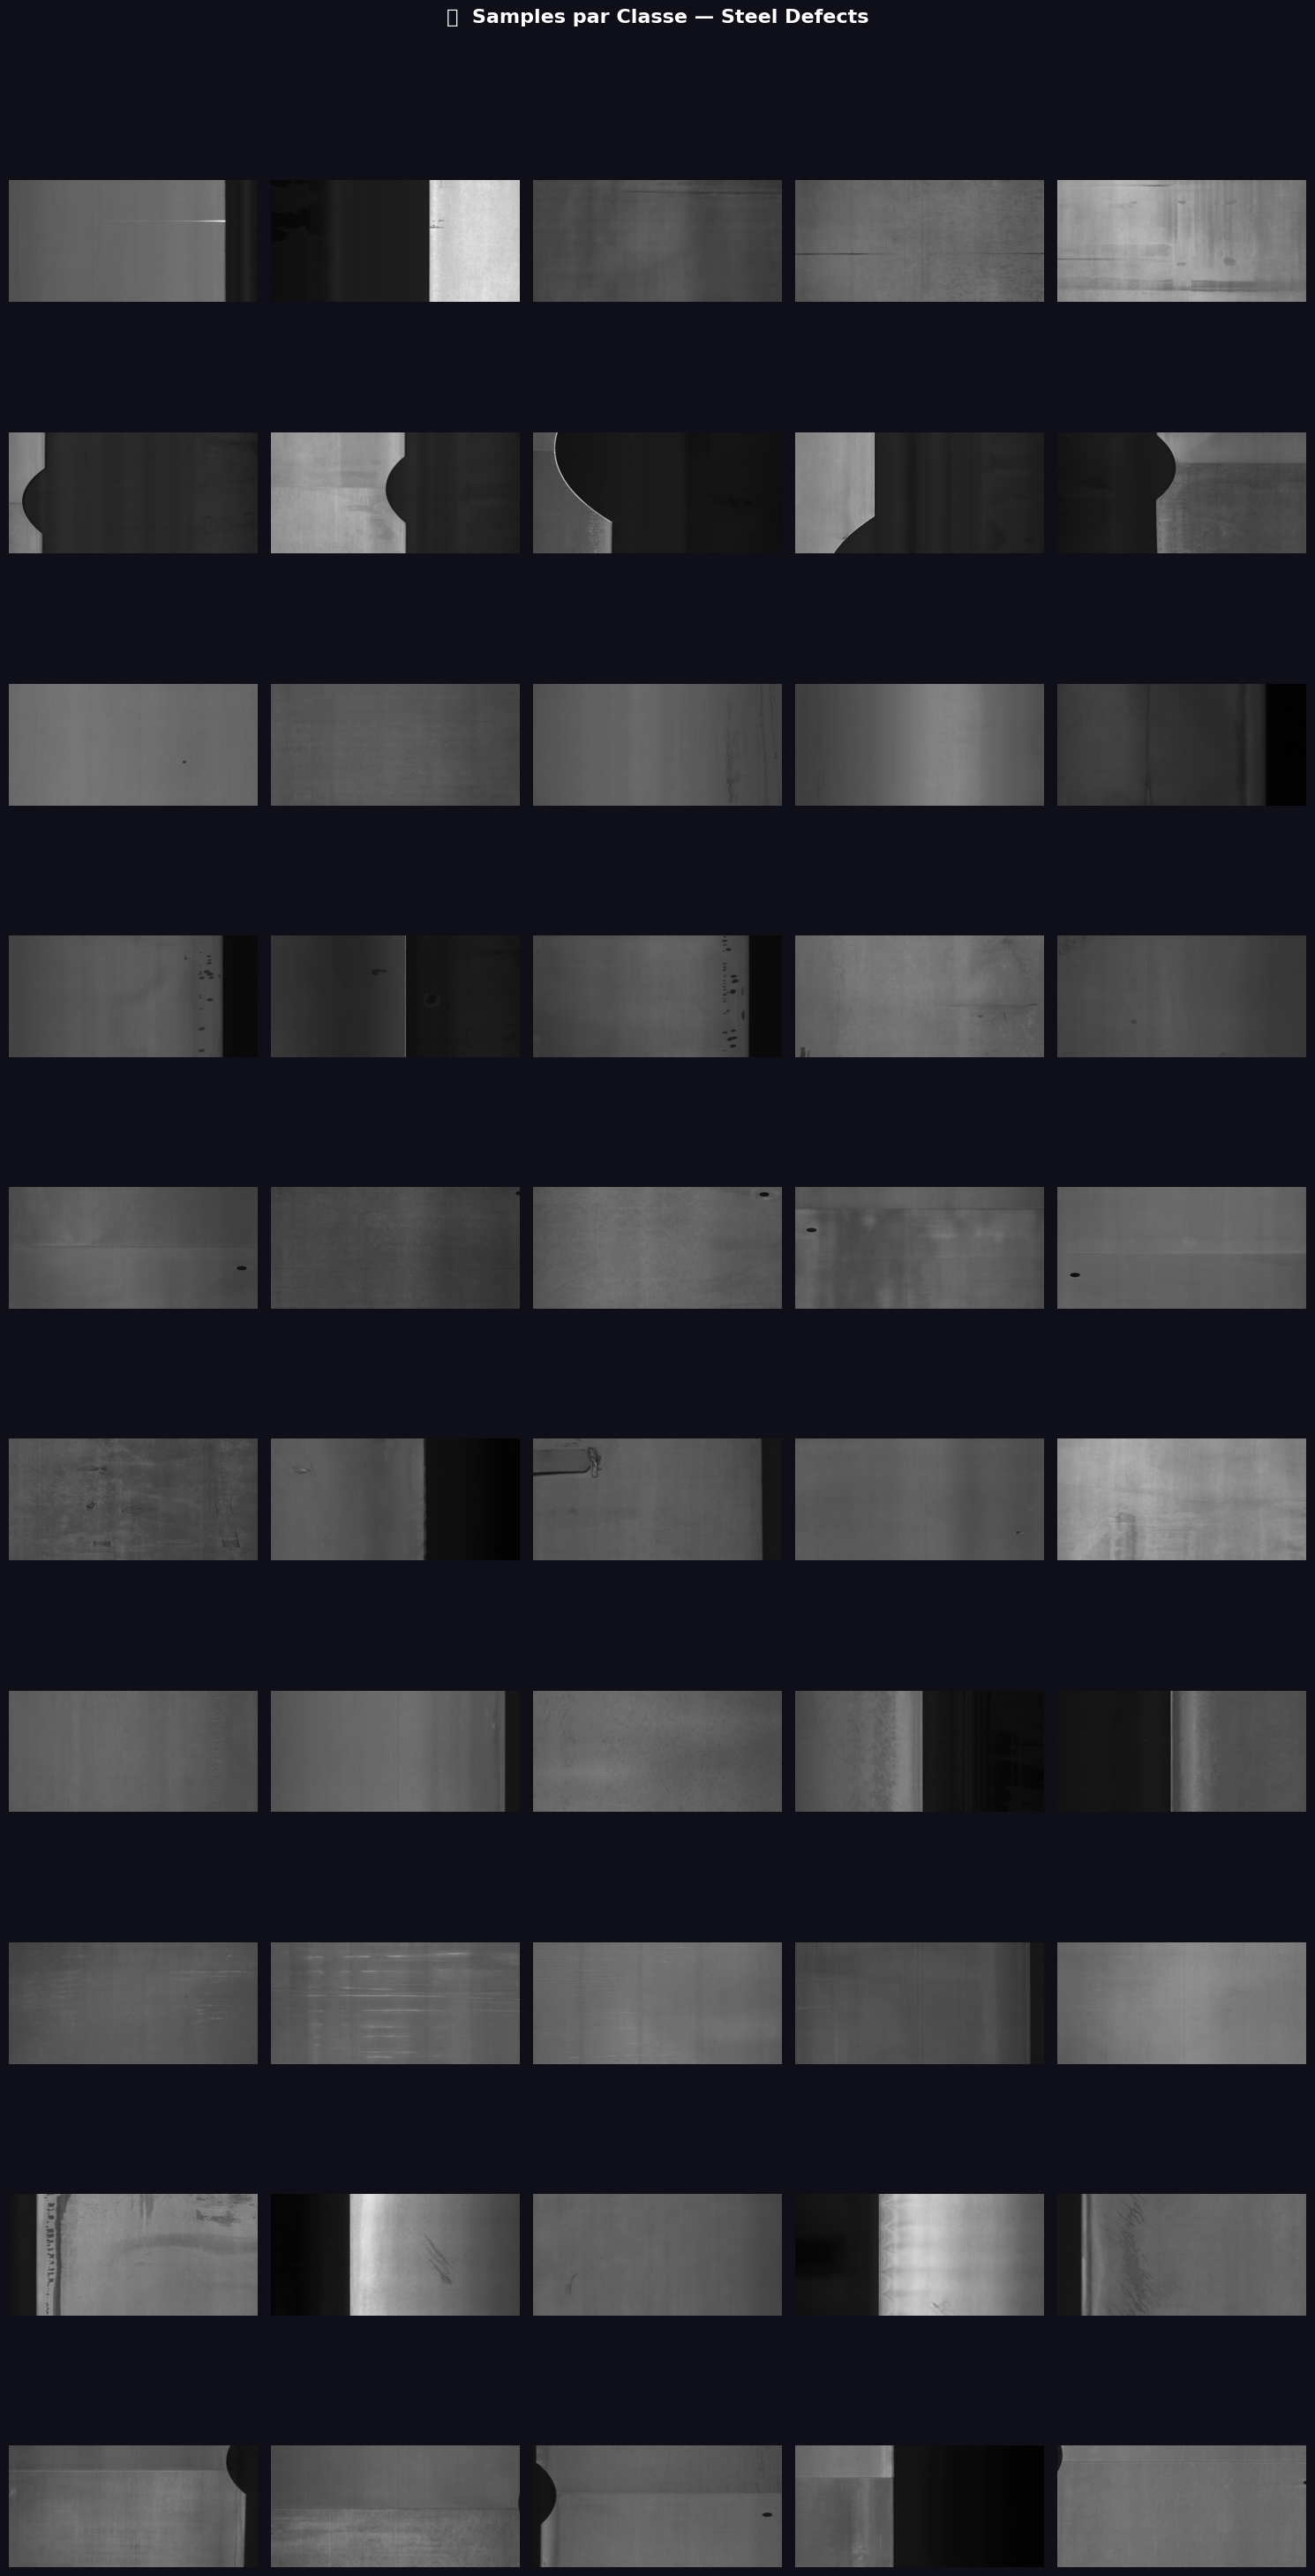

✅ Visualisation sauvegardée


In [31]:
N_SAMPLES = 5
n_classes = len(CLASSES)

fig, axes = plt.subplots(n_classes, N_SAMPLES,
                         figsize=(N_SAMPLES * 3, n_classes * 3))
fig.suptitle('🖼️  Samples par Classe — Steel Defects',
             fontsize=16, fontweight='bold',
             color='white', y=1.01)

for row, cls in enumerate(CLASSES):
    cls_path = IMG_DIR / cls
    images   = list(cls_path.glob("*.jpg")) + \
               list(cls_path.glob("*.png")) + \
               list(cls_path.glob("*.bmp"))
    
    # Shuffle pour varier les samples
    np.random.shuffle(images)
    samples = images[:N_SAMPLES]

    for col, img_path in enumerate(samples):
        ax = axes[row][col]
        try:
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img, cmap='gray')
        except:
            ax.text(0.5, 0.5, 'Error', ha='center',
                    color='red', transform=ax.transAxes)

        ax.axis('off')
        if col == 0:
            ax.set_ylabel(cls.replace('_',' ').title(),
                         color=PALETTE[row % len(PALETTE)],
                         fontsize=10, fontweight='bold',
                         rotation=0, labelpad=90, va='center')

plt.tight_layout()
plt.savefig(BASE_DIR / 'results/01_samples_par_classe.png',
            dpi=120, bbox_inches='tight',
            facecolor='#0f0f1a')
plt.show()
print("✅ Visualisation sauvegardée")

**Rapport Final**

In [32]:
# ============================================================
#  RAPPORT FINAL — DATA ENGINEERING
# ============================================================

# Recalcul local (au cas où les cellules précédentes ne sont pas exécutées)
mean_val   = df['n_images'].mean()
max_count  = df['n_images'].max()
min_count  = df['n_images'].min()
imb_ratio  = round(max_count / min_count, 2)

cls_max    = df.loc[df['n_images'].idxmax(), 'class']
cls_min    = df.loc[df['n_images'].idxmin(), 'class']

if imb_ratio > 3:
    imb_status = "🔴 Déséquilibre important"
elif imb_ratio > 1.5:
    imb_status = "🟡 Déséquilibre modéré"
else:
    imb_status = "🟢 Équilibré"

print("╔══════════════════════════════════════════════════════╗")
print("║          RAPPORT — DATA ENGINEERING                 ║")
print("╠══════════════════════════════════════════════════════╣")
print(f"║  📁 Classes          : {len(CLASSES):<28}║")
print(f"║  📸 Total images     : {df['n_images'].sum():<28}║")
print(f"║  📊 Moyenne/classe   : {mean_val:<28.1f}║")
print(f"║  📈 Classe max       : {cls_max+' ('+str(max_count)+')':<28}║")
print(f"║  📉 Classe min       : {cls_min+' ('+str(min_count)+')':<28}║")
print(f"║  ⚠️  Ratio imbalance  : {str(imb_ratio)+'x':<28}║")
print(f"║  🏷️  Statut           : {imb_status:<28}║")
print("╠══════════════════════════════════════════════════════╣")
print("║  ✅ RECOMMANDATIONS POUR NOTEBOOK 02                ║")
print("╠══════════════════════════════════════════════════════╣")
print("║  1. WeightedRandomSampler pour l'imbalance          ║")
print("║  2. Normalisation sur mean/std du dataset           ║")
print("║  3. Augmentation ciblée classes minoritaires        ║")
print("║  4. Resize uniforme toutes les images               ║")
print("╚══════════════════════════════════════════════════════╝")


╔══════════════════════════════════════════════════════╗
║          RAPPORT — DATA ENGINEERING                 ║
╠══════════════════════════════════════════════════════╣
║  📁 Classes          : 10                          ║
║  📸 Total images     : 2306                        ║
║  📊 Moyenne/classe   : 230.6                       ║
║  📈 Classe max       : silk_spot (650)             ║
║  📉 Classe min       : rolled_pit (31)             ║
║  ⚠️  Ratio imbalance  : 20.97x                      ║
║  🏷️  Statut           : 🔴 Déséquilibre important    ║
╠══════════════════════════════════════════════════════╣
║  ✅ RECOMMANDATIONS POUR NOTEBOOK 02                ║
╠══════════════════════════════════════════════════════╣
║  1. WeightedRandomSampler pour l'imbalance          ║
║  2. Normalisation sur mean/std du dataset           ║
║  3. Augmentation ciblée classes minoritaires        ║
║  4. Resize uniforme toutes les images               ║
╚══════════════════════════════════════════════════════